In [ ]:
!pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/dataset

angry  fear  happy  sad  surprise


In [ ]:
ls /content/drive/MyDrive/dataset/angry | head

IMG_5926.jpg
IMG_5930.jpg
IMG_5939.jpg
IMG_5940.jpg
IMG_5941.jpg
IMG_5942.jpg
IMG_5951.jpg
IMG_5952.jpg
IMG_5953.jpg
IMG_5954.jpg


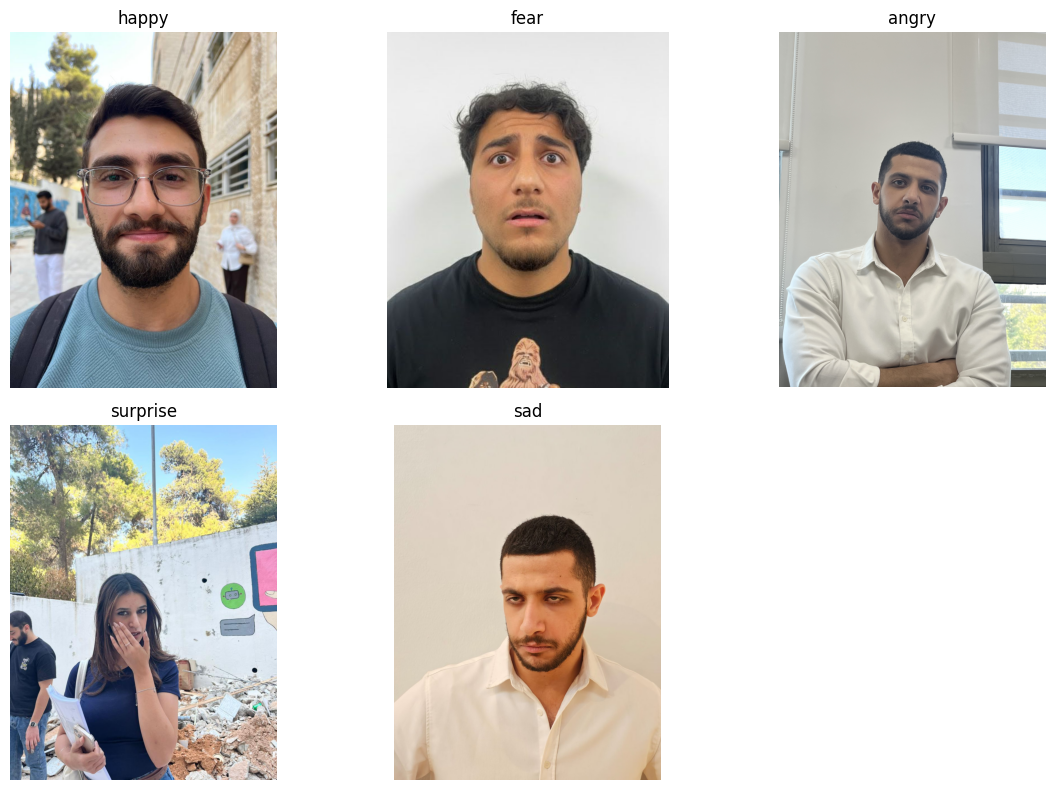

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

DATA_DIR = "/content/drive/MyDrive/dataset"
classes = os.listdir(DATA_DIR)

plt.figure(figsize=(12, 8))

i = 1
for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    # Filter to get only image files, ignoring subdirectories
    image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    if not image_files:
        print(f"No image files found in {cls_path}, skipping.")
        continue

    img_name = random.choice(image_files)
    img_path = os.path.join(cls_path, img_name)

    img = Image.open(img_path)

    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

    i += 1

plt.tight_layout()
plt.show()

In [ ]:
import os
CLASSES = ['angry','fear','happy','sad','surprise']

print("Number of images for each class: ")
for cls in CLASSES:
    cls_path = os.path.join(DATA_DIR, cls)

    if not os.path.exists(cls_path):
        print(f"{cls}: Not exixst")
        continue


    image_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

    print(f"{cls}: {len(image_files)}  images")

Number of images for each class: 
angry: 95  images
fear: 192  images
happy: 230  images
sad: 141  images
surprise: 85  images


In [ ]:
import os
import random
from PIL import Image
from collections import Counter

DATA_DIR = "/content/drive/MyDrive/dataset"
OUTPUT_DIR = "/content/drive/MyDrive/dataset_splits"
CLASSES = ['angry','fear','happy','sad','surprise']
SPLITS = (0.7, 0.2, 0.1)
TARGET_SIZE = (300, 300)

for split in ['train','val','test']:
    for cls in CLASSES:
        os.makedirs(os.path.join(OUTPUT_DIR, split, cls), exist_ok=True)

all_images = {}
class_counts = {cls: 0 for cls in CLASSES}

for cls in CLASSES:
    cls_path = os.path.join(DATA_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    all_images[cls] = images
    class_counts[cls] = len(images)
    print(f"{cls}: {len(images)} images")

total_samples = sum(class_counts.values())
class_weights = {}
for cls, count in class_counts.items():
    class_weights[cls] = total_samples / (len(CLASSES) * count)

print("\nClass Weights for Imbalanced Training:")
for cls, weight in class_weights.items():
    print(f"{cls}: {weight:.3f}")


for cls, images in all_images.items():
    random.shuffle(images)
    n_total = len(images)
    n_train = int(n_total * SPLITS[0])
    n_val   = int(n_total * SPLITS[1])

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train','val','test']):
        for idx, img in enumerate(img_list):
            src_path = os.path.join(DATA_DIR, cls, img)
            dst_name = f"{cls}_{idx}_{split}.jpg"
            dst_path = os.path.join(OUTPUT_DIR, split, cls, dst_name)

            try:
                im = Image.open(src_path).convert("RGB")
                im = im.resize(TARGET_SIZE)
                im.save(dst_path, "JPEG", quality=95)
            except Exception as e:
                print(f"Error processing {src_path}: {e}")

print("splitting  the dataset to train ,val ,test ")
print("class_weights :", class_weights)

angry: 95 images
fear: 192 images
happy: 230 images
sad: 141 images
surprise: 85 images

Class Weights for Imbalanced Training:
angry: 1.564
fear: 0.774
happy: 0.646
sad: 1.054
surprise: 1.748
splitting  the dataset to train ,val ,test 
class_weights : {'angry': 1.5642105263157895, 'fear': 0.7739583333333333, 'happy': 0.6460869565217391, 'sad': 1.0539007092198582, 'surprise': 1.748235294117647}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (300, 300)
BATCH    = 32
CLASSES  = ['angry','fear','happy','sad','surprise']
SEED     = 42

TRAIN = "/content/drive/MyDrive/dataset_splits/train"
VAL   = "/content/drive/MyDrive/dataset_splits/val"
TEST  = "/content/drive/MyDrive/dataset_splits/test"

# --- Augmentation ـ train only ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- Eval: validation & test (no augmentation) ---
eval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# --- Generators ---
train_gen = train_datagen.flow_from_directory(
    TRAIN,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=True,
    classes=CLASSES,
    seed=SEED
)

val_gen = eval_datagen.flow_from_directory(
    VAL,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False,
    classes=CLASSES
)

test_gen = eval_datagen.flow_from_directory(
    TEST,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False,
    classes=CLASSES
)

print("Class indices:", train_gen.class_indices)
print("Counts → Train:", train_gen.n, "Val:", val_gen.n, "Test:", test_gen.n)

Found 518 images belonging to 5 classes.
Found 148 images belonging to 5 classes.
Found 77 images belonging to 5 classes.
Class indices: {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'surprise': 4}
Counts → Train: 518 Val: 148 Test: 77


**######**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (300, 300)
BATCH_SIZE = 32
SEED = 42

TRAIN_DIR = "/content/drive/MyDrive/train"
VAL_DIR   = "/content/drive/MyDrive/val"
TEST_DIR  = "/content/drive/MyDrive/test"

# 🔹 Train (مع Augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# 🔹 Val & Test (بدون Augmentation)
eval_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = eval_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = eval_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 518 images belonging to 5 classes.
Found 148 images belonging to 5 classes.
Found 77 images belonging to 5 classes.
Class indices: {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'surprise': 4}


**######**

In [ ]:
print(train_gen.class_indices)


{'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'surprise': 4}


**######**

In [ ]:
CLASSES = ['angry','fear','happy','sad','surprise']

**######**

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# labels الحقيقية من train generator
y_train = train_gen.classes   # أرقام الكلاسات

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# نحولها لـ dict بالشكل المطلوب
class_weights = dict(enumerate(class_weights_array))

print("Class Weights:")
for k, v in class_weights.items():
    print(f"Class {k}: {v:.3f}")


Class Weights:
Class 0: 1.570
Class 1: 0.773
Class 2: 0.643
Class 3: 1.057
Class 4: 1.756


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow as tf

# --- Enhanced Model with Regularization ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300,300,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# BatchNorm + Dense + L2 regularization (Ridge)
x = BatchNormalization()(x)
x = Dense(256, activation='relu',
          kernel_regularizer=regularizers.l2(0.001))(x)  # Corrected: Added (x) to call the layer
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.001))(x)  # Corrected: Added (x) to call the layer
x = Dropout(0.4)(x)

output = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# --- Callbacks ---
early_stop = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, reduce_lr]

# --- Phase 1: Frozen Base ---
print("Phase 1: Training Frozen Base Model")
history_frozen = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

# --- Phase 2: Fine-tuning ---
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Phase 2: Fine-tuning Top Layers")
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

# --- Phase 3: Full Fine-tuning
print("Phase 3: Full Model Fine-tuning")
base_model.trainable = True  # Unfreeze everything

# Lower learning rate for full fine-tuning
model.compile(optimizer=Adam(5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_full = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,417,192 (16.85 MB)

 Trainable params: 364,549 (1.39 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

Phase 1: Training Frozen Base Model


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 130s 7s/step - accuracy: 0.2834 - loss: 2.7379 - val_accuracy: 0.6419 - val_loss: 1.8543 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - accuracy: 0.3798 - loss: 2.1406 - val_accuracy: 0.7095 - val_loss: 1.7219 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.4931 - loss: 1.8132 - val_accuracy: 0.7635 - val_loss: 1.6510 - learning_rate: 0.0010
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.5645 - loss: 1.6861 - val_accuracy: 0.7770 - val_loss: 1.5845 - learning_rate: 0.0010
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - accuracy: 0.5813 - loss: 1.5688 - val_accuracy: 0.7568 - val_loss: 1.5308 - learning_rate: 0.0010
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.5931 - loss: 1.5598 - val_accuracy: 0.7635 - val_loss: 1.4655 - learning_rate: 0.0010
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - accuracy: 0.6578 - loss: 1.4092 - val_acc

In [ ]:
# import tensorflow as tf
# tf.keras.backend.clear_session()

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/efficientnetB0_emotions.h5"
# Removed: model.load_weights(MODEL_PATH) # This line caused the FileNotFoundError
model.save(MODEL_PATH)
print(f"Model saved at: {MODEL_PATH}")

Model saved at: /content/drive/MyDrive/efficientnetB0_emotions.h5


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import itertools

# --- Predictions ----
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
y_pred_proba = preds

# --- Overall Metrics ---
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("Model Perfornmance")
print("=" * 50)
print(f"Accuracy:        {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro):  {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# --- ROC-AUC ---
y_true_bin = label_binarize(y_true, classes=range(len(CLASSES)))
roc_auc_macro = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC (Macro):  {roc_auc_macro:.4f}")

print("\n\n\n")

# --- Classification Report ---
print("\nCLASSIFICATION REPORT")
# print(classification_report(y_true, y_pred, target_names=CLASSES))
labels = list(range(len(CLASSES)))

print(classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=CLASSES,
    zero_division=0
))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step
Model Perfornmance
Accuracy:        0.8571 (85.71%)
F1-Score (Macro):  0.8508
F1-Score (Weighted): 0.8587
ROC-AUC (Macro):  0.9668





CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.83      1.00      0.91        10
        fear       0.89      0.85      0.87        20
       happy       0.95      0.83      0.88        23
         sad       0.86      0.80      0.83        15
    surprise       0.67      0.89      0.76         9

    accuracy                           0.86        77
   macro avg       0.84      0.87      0.85        77
weighted avg       0.87      0.86      0.86        77



**######**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow as tf

# --- Enhanced Model with Regularization ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300,300,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# BatchNorm + Dense + L2 regularization (Ridge)
x = BatchNormalization()(x)
x = Dense(256, activation='gelu',
          kernel_regularizer=regularizers.l2(0.001))(x)  # Corrected: Added (x) to call the layer
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='gelu',
          kernel_regularizer=regularizers.l2(0.001))(x)  # Corrected: Added (x) to call the layer
x = Dropout(0.4)(x)

output = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# --- Callbacks ---
early_stop = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, reduce_lr]

# --- Phase 1: Frozen Base ---
print("Phase 1: Training Frozen Base Model")
history_frozen = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

# --- Phase 2: Fine-tuning ---
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-3, clipnorm=1.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Phase 2: Fine-tuning Top Layers")
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

# --- Phase 3: Full Fine-tuning
print("Phase 3: Full Model Fine-tuning")
base_model.trainable = True  # Unfreeze everything

# Lower learning rate for full fine-tuning
model.compile(optimizer=Adam(5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_full = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,417,192 (16.85 MB)

 Trainable params: 364,549 (1.39 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

Phase 1: Training Frozen Base Model
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 160s 8s/step - accuracy: 0.2531 - loss: 2.5717 - val_accuracy: 0.5000 - val_loss: 1.9449 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 132s 8s/step - accuracy: 0.4375 - loss: 1.9854 - val_accuracy: 0.5946 - val_loss: 1.8195 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.5323 - loss: 1.7860 - val_accuracy: 0.6081 - val_loss: 1.7467 - learning_rate: 0.0010
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.5839 - loss: 1.6384 - val_accuracy: 0.6014 - val_loss: 1.6790 - learning_rate: 0.0010
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.5873 - loss: 1.6059 - val_accuracy: 0.6486 - val_loss: 1.5824 - learning_rate: 0.0010
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 0.6681 - loss: 1.4040 - val_accuracy: 0.6892 - val_loss: 1.4941 - learning_rate: 0.0010
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - accur

**######**

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import itertools

# --- Predictions ----
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
y_pred_proba = preds

# --- Overall Metrics ---
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("Model Perfornmance")
print("=" * 50)
print(f"Accuracy:        {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro):  {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# --- ROC-AUC ---
y_true_bin = label_binarize(y_true, classes=range(len(CLASSES)))
roc_auc_macro = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC (Macro):  {roc_auc_macro:.4f}")

print("\n\n\n")

# --- Classification Report ---
print("\nCLASSIFICATION REPORT")
# print(classification_report(y_true, y_pred, target_names=CLASSES))
labels = list(range(len(CLASSES)))

print(classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=CLASSES,
    zero_division=0
))


2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step
Model Perfornmance
Accuracy:        0.9221 (92.21%)
F1-Score (Macro):  0.9021
F1-Score (Weighted): 0.9228
ROC-AUC (Macro):  0.9729





CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.90      0.90      0.90        10
        fear       0.95      1.00      0.98        20
       happy       1.00      0.96      0.98        23
         sad       0.92      0.80      0.86        15
    surprise       0.73      0.89      0.80         9

    accuracy                           0.92        77
   macro avg       0.90      0.91      0.90        77
weighted avg       0.93      0.92      0.92        77



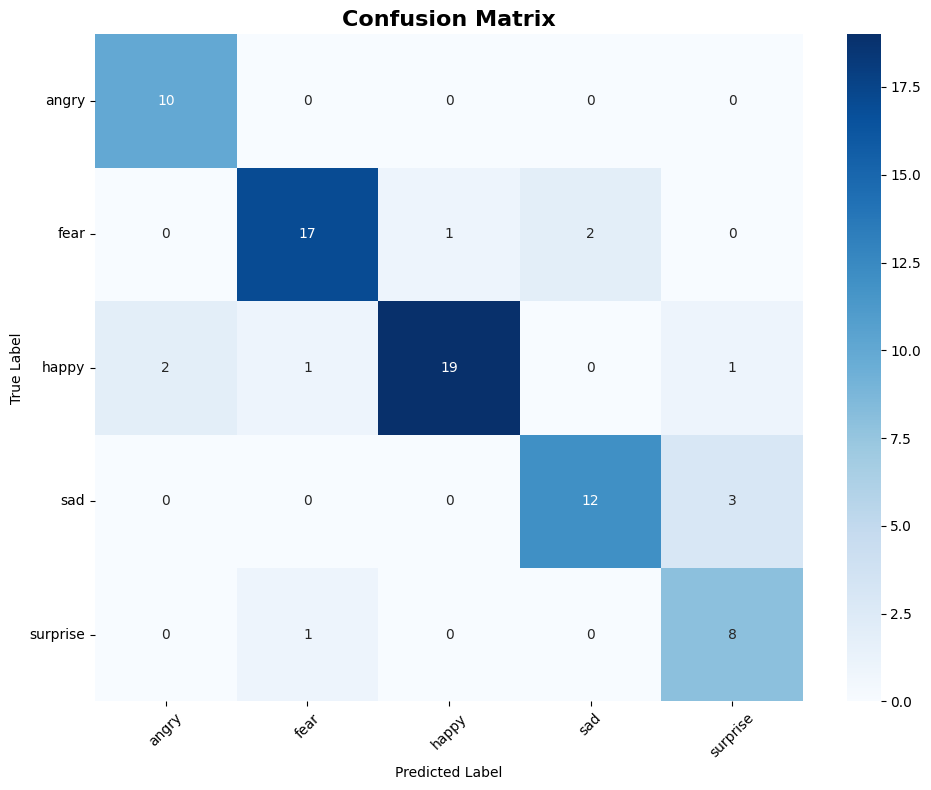

In [ ]:
# ---Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**######**

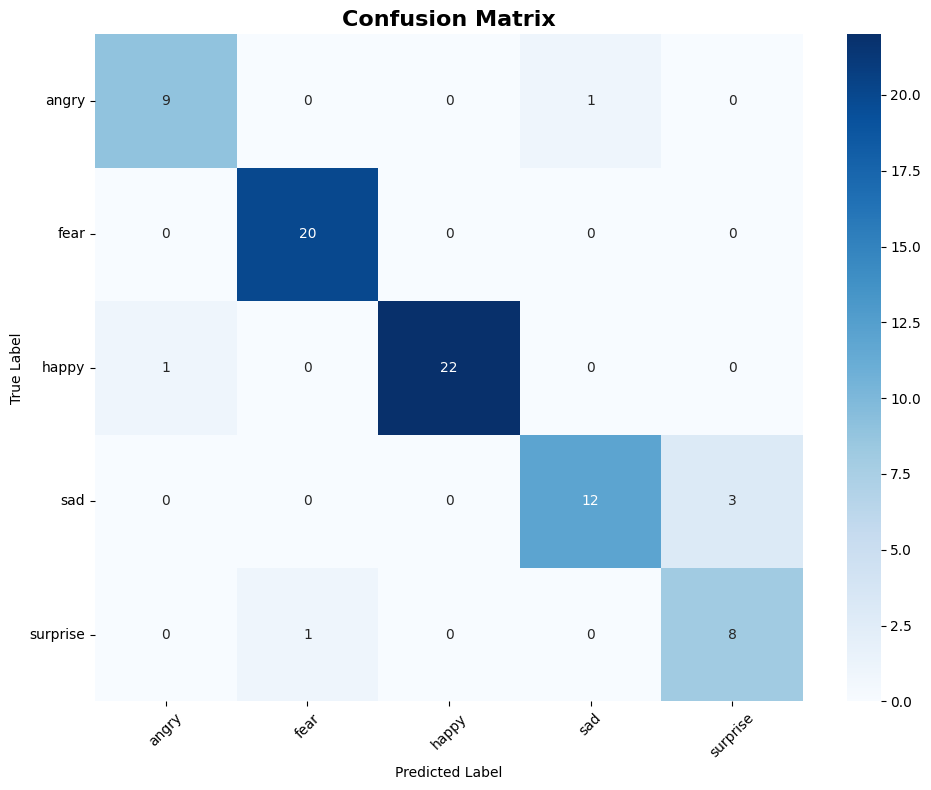

In [ ]:
# ---Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

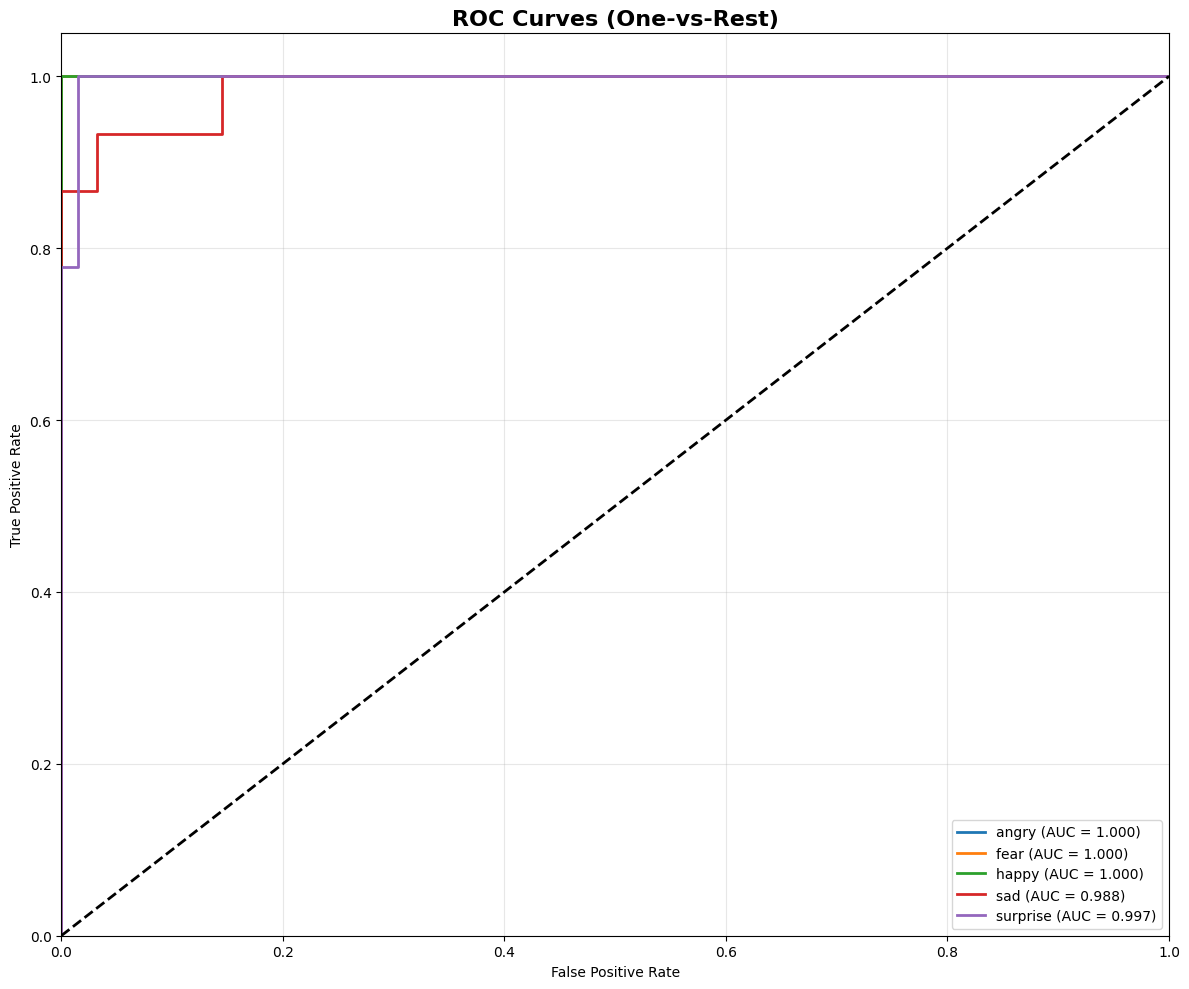

In [ ]:
# ---ROC Curves ---
plt.figure(figsize=(12, 10))
for i, cls in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2,
             label=f'{cls} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

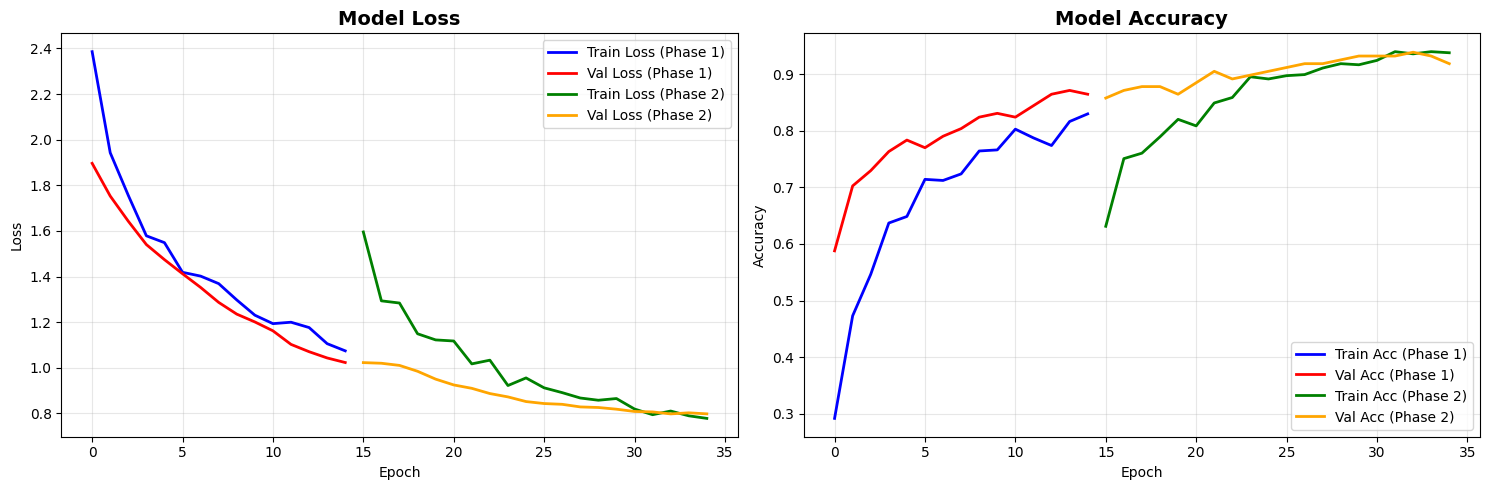

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Loss Curve ---
ax1.plot(history_frozen.history['loss'], label='Train Loss (Phase 1)', color='blue', linewidth=2)
ax1.plot(history_frozen.history['val_loss'], label='Val Loss (Phase 1)', color='red', linewidth=2)

if 'history_finetune' in globals():
    epochs1 = len(history_frozen.history['loss'])
    ax1.plot(range(epochs1, epochs1+len(history_finetune.history['loss'])),
            history_finetune.history['loss'], label='Train Loss (Phase 2)', color='green', linewidth=2)
    ax1.plot(range(epochs1, epochs1+len(history_finetune.history['val_loss'])),
            history_finetune.history['val_loss'], label='Val Loss (Phase 2)', color='orange', linewidth=2)

ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ---Accuracy Curve ---
ax2.plot(history_frozen.history['accuracy'], label='Train Acc (Phase 1)', color='blue', linewidth=2)
ax2.plot(history_frozen.history['val_accuracy'], label='Val Acc (Phase 1)', color='red', linewidth=2)

if 'history_finetune' in globals():
    epochs1 = len(history_frozen.history['accuracy'])
    ax2.plot(range(epochs1, epochs1+len(history_finetune.history['accuracy'])),
            history_finetune.history['accuracy'], label='Train Acc (Phase 2)', color='green', linewidth=2)
    ax2.plot(range(epochs1, epochs1+len(history_finetune.history['val_accuracy'])),
            history_finetune.history['val_accuracy'], label='Val Acc (Phase 2)', color='orange', linewidth=2)

ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**######**

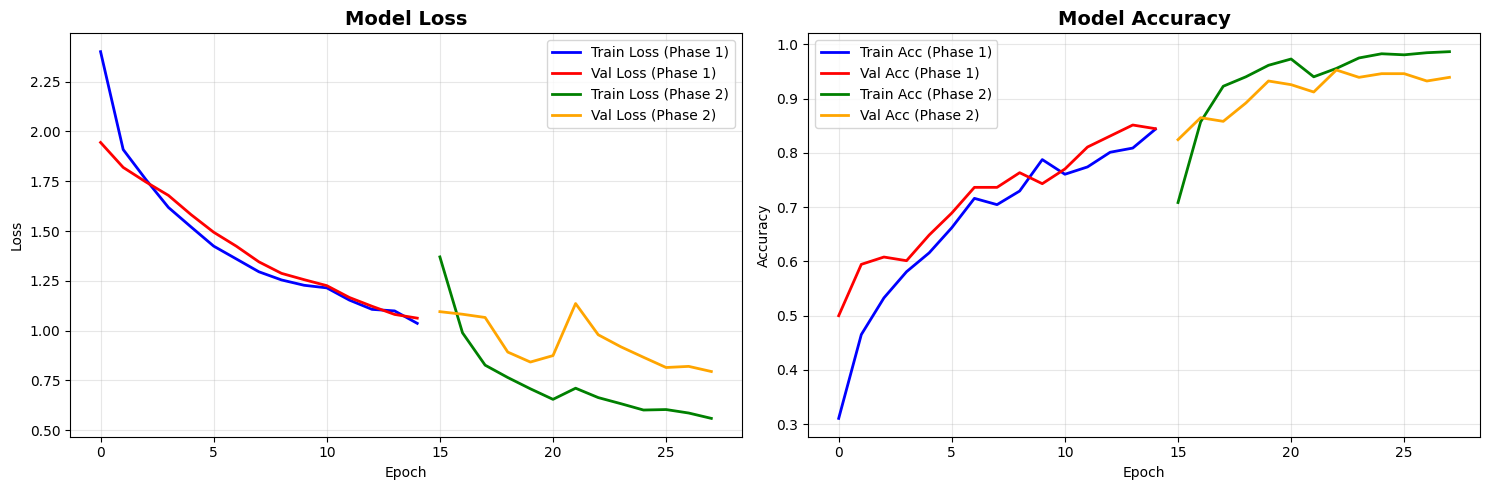

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Loss Curve ---
ax1.plot(history_frozen.history['loss'], label='Train Loss (Phase 1)', color='blue', linewidth=2)
ax1.plot(history_frozen.history['val_loss'], label='Val Loss (Phase 1)', color='red', linewidth=2)

if 'history_finetune' in globals():
    epochs1 = len(history_frozen.history['loss'])
    ax1.plot(range(epochs1, epochs1+len(history_finetune.history['loss'])),
            history_finetune.history['loss'], label='Train Loss (Phase 2)', color='green', linewidth=2)
    ax1.plot(range(epochs1, epochs1+len(history_finetune.history['val_loss'])),
            history_finetune.history['val_loss'], label='Val Loss (Phase 2)', color='orange', linewidth=2)

ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ---Accuracy Curve ---
ax2.plot(history_frozen.history['accuracy'], label='Train Acc (Phase 1)', color='blue', linewidth=2)
ax2.plot(history_frozen.history['val_accuracy'], label='Val Acc (Phase 1)', color='red', linewidth=2)

if 'history_finetune' in globals():
    epochs1 = len(history_frozen.history['accuracy'])
    ax2.plot(range(epochs1, epochs1+len(history_finetune.history['accuracy'])),
            history_finetune.history['accuracy'], label='Train Acc (Phase 2)', color='green', linewidth=2)
    ax2.plot(range(epochs1, epochs1+len(history_finetune.history['val_accuracy'])),
            history_finetune.history['val_accuracy'], label='Val Acc (Phase 2)', color='orange', linewidth=2)

ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
#Number of misclassified images
import numpy as np

misclassified = []

idx = 0  # مؤشر عام

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    for i in range(len(labels)):
        if labels[i].numpy() != pred_labels[i]:
            misclassified.append((
                images[i].numpy(),
                labels[i].numpy(),
                pred_labels[i]
            ))
        idx += 1

print(f"Number of misclassified images: {len(misclassified)}")

In [ ]:
import matplotlib.pyplot as plt

num_show = 10  # عدد الصور اللي  هتنعرض
plt.figure(figsize=(15, 8))

for i in range(min(num_show, len(misclassified))):
    img, true_label, pred_label = misclassified[i]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
        fontsize=10
    )
    plt.axis("off")

plt.suptitle("Misclassified Test Images", fontsize=16)
plt.tight_layout()
plt.show()